## This code takes the college basketball data and models it using logistic regression

In [36]:
#import packages

import pandas as pd
import numpy as np
#import time

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from pprint import pprint
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc

#import requests
from sklearn.feature_selection import RFE, RFECV
from sklearn.decomposition import PCA, IncrementalPCA

In [100]:
#creating functions to evaluate model fit

def get_preds(threshold, probabilities):
    return [1 if prob > threshold else 0 for prob in probabilities]


def evaluate_classification(model, test_features, test_labels, extra = False):
    
    predictions = model.predict(test_features)
    
    accuracy = sum(predictions == test_labels)/len(test_labels)
    
    class_rep = classification_report(test_labels, predictions, digits = 4)
    
    cf_matrix = confusion_matrix(test_labels, predictions)

    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', xticklabels = ['Predicted Loss', 'Predicted Win'],
               yticklabels = ['Actual Loss', 'Actual Win'])
    

    print('Model Performance\n')
    print('Accuracy = ',(accuracy),'\n')
    print('Classification Report\n')
    print(class_rep)
    plt.show()
    
    
    
    if extra == True:
        
        print('Area Under the Curve =', roc_auc_score(test_labels, predictions))
        
        probas = model.predict_proba(test_features)[:, 1]
        
        roc_values = []
        for thresh in np.linspace(0, 1, 100):
            preds = get_preds(thresh, probas)
            tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
            tpr = tp/(tp+fn)
            fpr = fp/(fp+tn)
            roc_values.append([tpr, fpr])
            
        tpr_values, fpr_values = zip(*roc_values)
        
        fig, ax = plt.subplots(figsize=(10,7))
        ax.plot(fpr_values, tpr_values)
        ax.plot(np.linspace(0, 1, 100),
        np.linspace(0, 1, 100),
        label='baseline',
        linestyle='--')
        plt.title('Receiver Operating Characteristic Curve', fontsize=18)
        plt.ylabel('TPR', fontsize=16)
        plt.xlabel('FPR', fontsize=16)
        plt.legend(fontsize=12)
        
        plt.show()
        
def compare_classification(model1, model2, test_features1, test_features2, test_labels):
    
    predictions1 = model1.predict(test_features1)
    predictions2 = model2.predict(test_features2)
    
    accuracy1 = sum(predictions1 == test_labels)/len(test_labels)
    accuracy2 = sum(predictions2 == test_labels)/len(test_labels)
    
    class_rep1 = classification_report(test_labels, predictions1, digits = 4)
    class_rep2 = classification_report(test_labels, predictions2, digits = 4)
    
    diff = accuracy2 - accuracy1
    
    print('           Model 1 Performance   ', 'Model 2 Performance', '  Difference (Model2 - Model1)')
    print('Accuracy: ',(accuracy1),"   ",(accuracy2),"   ",(diff))

## Importing data and conducting minor cleaning including converting the outcome varible to 0/1, then setting up training and testing sets

In [4]:
#import data
full_data = pd.read_csv("College Data/Weighted Mean Converted Data.csv")

In [5]:
#inspect data columns
full_data.columns

Index(['Date', 'G', 'Opp', 'W/L', 'Opp.1', 'Tm', 'Team', 'Location', 'FG',
       'FGA', 'FG%', '3P', '3PA', '3P%', 'FT', 'FTA', 'FT%', 'ORB', 'TRB',
       'AST', 'STL', 'BLK', 'TOV', 'PF', 'eFG', 'TOV%', 'ORB%', 'FT/FGA',
       'DRB%', 'AST%', 'TS%', '3PAr', 'DRB', 'POSS', 'OffRt', 'DefRt', 'FG.1',
       'FGA.1', 'FG%.1', '3P.1', '3PA.1', '3P%.1', 'FT.1', 'FTA.1', 'FT%.1',
       'ORB.1', 'TRB.1', 'AST.1', 'STL.1', 'BLK.1', 'TOV.1', 'PF.1', 'eFG.1',
       'TOV%.1', 'ORB%.1', 'FT/FGA.1', 'DRB%.1', 'AST%.1', 'TS%.1', '3PAr.1',
       'DRB.1', 'POSS.1', 'OffRt.1', 'DefRt.1'],
      dtype='object')

In [7]:
full_data.head()

,Date,G,Opp,W/L,Opp.1,Tm,Team,Location,FG,FGA,...,ORB%.1,FT/FGA.1,DRB%.1,AST%.1,TS%.1,3PAr.1,DRB.1,POSS.1,OffRt.1,DefRt.1
0,2022-11-11,2,texas-am,L,77,58,abilene-christian,A,23.000000,57.000000,...,0.264706,0.174603,0.813953,0.656250,0.613367,0.412698,35.000000,75.920000,114.594310,71.127503
1,2022-11-21,4,wright-state,L,77,61,abilene-christian,N,31.000000,60.833333,...,0.291657,0.214480,0.806891,0.425512,0.633018,0.185174,27.700000,75.756000,117.233591,89.383734
2,2022-11-22,5,weber-state,L,77,67,abilene-christian,N,28.600000,59.700000,...,0.139543,0.301987,0.795111,0.436316,0.530863,0.405271,23.300000,66.932000,94.437727,107.999632
3,2022-11-23,6,california-riverside,L,76,65,abilene-christian,N,27.733333,57.466667,...,0.249515,0.118953,0.856104,0.486961,0.566101,0.417359,28.380952,70.076190,107.410494,89.856350
4,2022-11-27,7,northern-arizona,W,82,92,abilene-christian,A,26.095238,58.190476,...,0.281522,0.178352,0.713698,0.581618,0.511688,0.412427,21.535714,72.134286,97.167696,98.975669


In [8]:
#converting Location variable with one-hot encoding (dummy coding)

full_data_adv = pd.get_dummies(full_data, columns = ['Location'])

full_data_adv.head()

,Date,G,Opp,W/L,Opp.1,Tm,Team,FG,FGA,FG%,...,AST%.1,TS%.1,3PAr.1,DRB.1,POSS.1,OffRt.1,DefRt.1,Location_A,Location_H,Location_N
0,2022-11-11,2,texas-am,L,77,58,abilene-christian,23.000000,57.000000,0.404000,...,0.656250,0.613367,0.412698,35.000000,75.920000,114.594310,71.127503,1,0,0
1,2022-11-21,4,wright-state,L,77,61,abilene-christian,31.000000,60.833333,0.497167,...,0.425512,0.633018,0.185174,27.700000,75.756000,117.233591,89.383734,0,0,1
2,2022-11-22,5,weber-state,L,77,67,abilene-christian,28.600000,59.700000,0.470700,...,0.436316,0.530863,0.405271,23.300000,66.932000,94.437727,107.999632,0,0,1
3,2022-11-23,6,california-riverside,L,76,65,abilene-christian,27.733333,57.466667,0.477467,...,0.486961,0.566101,0.417359,28.380952,70.076190,107.410494,89.856350,0,0,1
4,2022-11-27,7,northern-arizona,W,82,92,abilene-christian,26.095238,58.190476,0.445905,...,0.581618,0.511688,0.412427,21.535714,72.134286,97.167696,98.975669,1,0,0


In [9]:
full_data_adv.columns

Index(['Date', 'G', 'Opp', 'W/L', 'Opp.1', 'Tm', 'Team', 'FG', 'FGA', 'FG%',
       '3P', '3PA', '3P%', 'FT', 'FTA', 'FT%', 'ORB', 'TRB', 'AST', 'STL',
       'BLK', 'TOV', 'PF', 'eFG', 'TOV%', 'ORB%', 'FT/FGA', 'DRB%', 'AST%',
       'TS%', '3PAr', 'DRB', 'POSS', 'OffRt', 'DefRt', 'FG.1', 'FGA.1',
       'FG%.1', '3P.1', '3PA.1', '3P%.1', 'FT.1', 'FTA.1', 'FT%.1', 'ORB.1',
       'TRB.1', 'AST.1', 'STL.1', 'BLK.1', 'TOV.1', 'PF.1', 'eFG.1', 'TOV%.1',
       'ORB%.1', 'FT/FGA.1', 'DRB%.1', 'AST%.1', 'TS%.1', '3PAr.1', 'DRB.1',
       'POSS.1', 'OffRt.1', 'DefRt.1', 'Location_A', 'Location_H',
       'Location_N'],
      dtype='object')

In [10]:
#creating overtime variable

full_data_adv['OT'] = full_data_adv['W/L'].str.split().str[2].str[0:2]
full_data_adv['OT'].fillna(0, inplace = True)
full_data_adv['OT'].replace('OT', 1, inplace = True)

In [11]:
#examining outcome variable values
full_data_adv['W/L'].unique()

array(['L', 'W', 'L\xa0(2 OT)', 'L\xa0(1 OT)', 'W\xa0(1 OT)',
       'W\xa0(4 OT)', 'W\xa0(2 OT)', 'W\xa0(3 OT)', 'L\xa0(3 OT)',
       'L\xa0(4 OT)'], dtype=object)

In [12]:
#removing extra text in win loss variable
full_data_adv['W/L'] = full_data_adv['W/L'].str.split().str[0]
full_data_adv['W/L'].unique()

array(['L', 'W'], dtype=object)

In [13]:
#Converting outcome variable from string to numeric
full_data_adv.replace({"W/L": {"W":1, "L":0}}, inplace = True)

In [14]:
#looking at cleaned data
full_data_adv.head()

,Date,G,Opp,W/L,Opp.1,Tm,Team,FG,FGA,FG%,...,TS%.1,3PAr.1,DRB.1,POSS.1,OffRt.1,DefRt.1,Location_A,Location_H,Location_N,OT
0,2022-11-11,2,texas-am,0,77,58,abilene-christian,23.000000,57.000000,0.404000,...,0.613367,0.412698,35.000000,75.920000,114.594310,71.127503,1,0,0,0
1,2022-11-21,4,wright-state,0,77,61,abilene-christian,31.000000,60.833333,0.497167,...,0.633018,0.185174,27.700000,75.756000,117.233591,89.383734,0,0,1,0
2,2022-11-22,5,weber-state,0,77,67,abilene-christian,28.600000,59.700000,0.470700,...,0.530863,0.405271,23.300000,66.932000,94.437727,107.999632,0,0,1,0
3,2022-11-23,6,california-riverside,0,76,65,abilene-christian,27.733333,57.466667,0.477467,...,0.566101,0.417359,28.380952,70.076190,107.410494,89.856350,0,0,1,0
4,2022-11-27,7,northern-arizona,1,82,92,abilene-christian,26.095238,58.190476,0.445905,...,0.511688,0.412427,21.535714,72.134286,97.167696,98.975669,1,0,0,0


In [15]:
#examining number of rows and columns of cleaned data
full_data_adv.shape

(10693, 67)

In [16]:
#examining all variable types
pd.options.display.max_rows = 70
print(full_data_adv.dtypes)
pd.options.display.max_rows = 10

Date           object
G               int64
Opp            object
W/L             int64
Opp.1           int64
Tm              int64
Team           object
FG            float64
FGA           float64
FG%           float64
3P            float64
3PA           float64
3P%           float64
FT            float64
FTA           float64
FT%           float64
ORB           float64
TRB           float64
AST           float64
STL           float64
BLK           float64
TOV           float64
PF            float64
eFG           float64
TOV%          float64
ORB%          float64
FT/FGA        float64
DRB%          float64
AST%          float64
TS%           float64
3PAr          float64
DRB           float64
POSS          float64
OffRt         float64
DefRt         float64
FG.1          float64
FGA.1         float64
FG%.1         float64
3P.1          float64
3PA.1         float64
3P%.1         float64
FT.1          float64
FTA.1         float64
FT%.1         float64
ORB.1         float64
TRB.1     

In [17]:
#droping any duplicate rows
full_data_adv.dropna().drop_duplicates()
full_data_adv.shape

(10693, 67)

In [18]:
#columns that will not be used as features



fields_to_drop = ['G', 'Date', 'Opp', 'W/L', 'Opp.1', 'Tm', 'Team', 'OT', 'Location_A', 'Location_H', 'Location_N']

#fields_to_keep = []



In [20]:
full_data_adv.head()

,Date,G,Opp,W/L,Opp.1,Tm,Team,FG,FGA,FG%,...,TS%.1,3PAr.1,DRB.1,POSS.1,OffRt.1,DefRt.1,Location_A,Location_H,Location_N,OT
0,2022-11-11,2,texas-am,0,77,58,abilene-christian,23.000000,57.000000,0.404000,...,0.613367,0.412698,35.000000,75.920000,114.594310,71.127503,1,0,0,0
1,2022-11-21,4,wright-state,0,77,61,abilene-christian,31.000000,60.833333,0.497167,...,0.633018,0.185174,27.700000,75.756000,117.233591,89.383734,0,0,1,0
2,2022-11-22,5,weber-state,0,77,67,abilene-christian,28.600000,59.700000,0.470700,...,0.530863,0.405271,23.300000,66.932000,94.437727,107.999632,0,0,1,0
3,2022-11-23,6,california-riverside,0,76,65,abilene-christian,27.733333,57.466667,0.477467,...,0.566101,0.417359,28.380952,70.076190,107.410494,89.856350,0,0,1,0
4,2022-11-27,7,northern-arizona,1,82,92,abilene-christian,26.095238,58.190476,0.445905,...,0.511688,0.412427,21.535714,72.134286,97.167696,98.975669,1,0,0,0


In [21]:
#creating feature data and examining number of rows and columns

X = full_data_adv.drop(columns = fields_to_drop)

print(X.shape)
X.columns

(10693, 56)


Index(['FG', 'FGA', 'FG%', '3P', '3PA', '3P%', 'FT', 'FTA', 'FT%', 'ORB',
       'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'eFG', 'TOV%', 'ORB%',
       'FT/FGA', 'DRB%', 'AST%', 'TS%', '3PAr', 'DRB', 'POSS', 'OffRt',
       'DefRt', 'FG.1', 'FGA.1', 'FG%.1', '3P.1', '3PA.1', '3P%.1', 'FT.1',
       'FTA.1', 'FT%.1', 'ORB.1', 'TRB.1', 'AST.1', 'STL.1', 'BLK.1', 'TOV.1',
       'PF.1', 'eFG.1', 'TOV%.1', 'ORB%.1', 'FT/FGA.1', 'DRB%.1', 'AST%.1',
       'TS%.1', '3PAr.1', 'DRB.1', 'POSS.1', 'OffRt.1', 'DefRt.1'],
      dtype='object')

In [22]:
#Create outcome data

y = full_data_adv['W/L'].values


y.shape

(10693,)

In [25]:
#Create training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 42)

In [26]:
#Standardizing the predictor variables into Z scores

scaler = preprocessing.StandardScaler()
X_train_std = pd.DataFrame(scaler.fit_transform(X_train))
X_train_std.columns = X_train.columns
X_test_std = pd.DataFrame(scaler.transform(X_test))
X_test_std.columns = X_test.columns

## Running a basic logistic regression model and examining the results

In [27]:
#create basic logistic regression object
logreg = LogisticRegression(random_state = 42, max_iter = 1000)

In [28]:
#fit basic logistic regression model to training data
logreg.fit(X_train_std,y_train)

LogisticRegression(max_iter=1000, random_state=42)

Model Performance

Accuracy =  0.6394913986537023 

Classification Report

              precision    recall  f1-score   support

           0     0.6433    0.6405    0.6419      1349
           1     0.6356    0.6385    0.6370      1325

    accuracy                         0.6395      2674
   macro avg     0.6395    0.6395    0.6395      2674
weighted avg     0.6395    0.6395    0.6395      2674



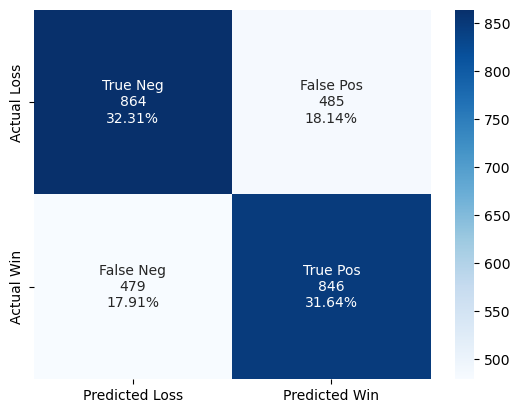

Area Under the Curve = 0.6394824957690532


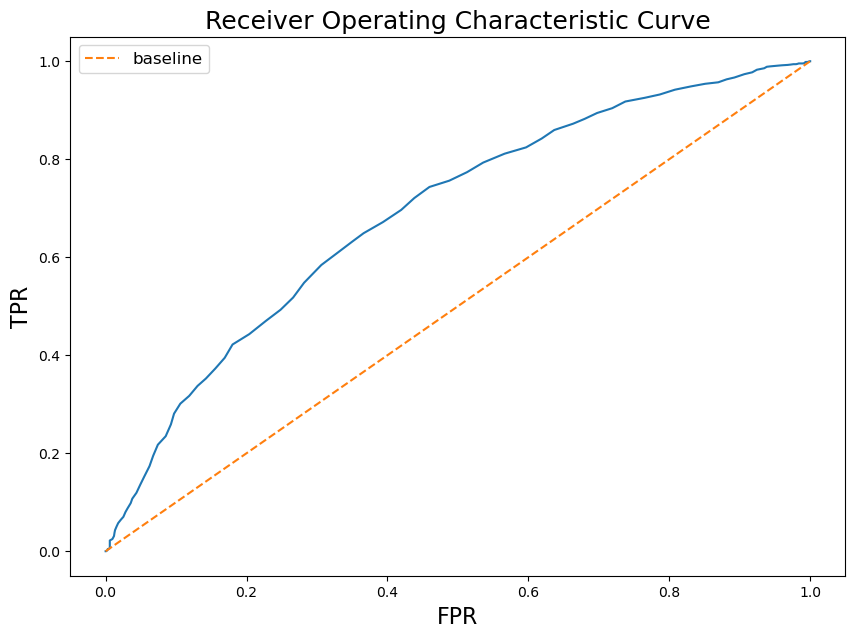

In [33]:
#evaluate trained logistic regression model on test data

evaluate_classification(logreg, X_test_std, y_test, extra = True)

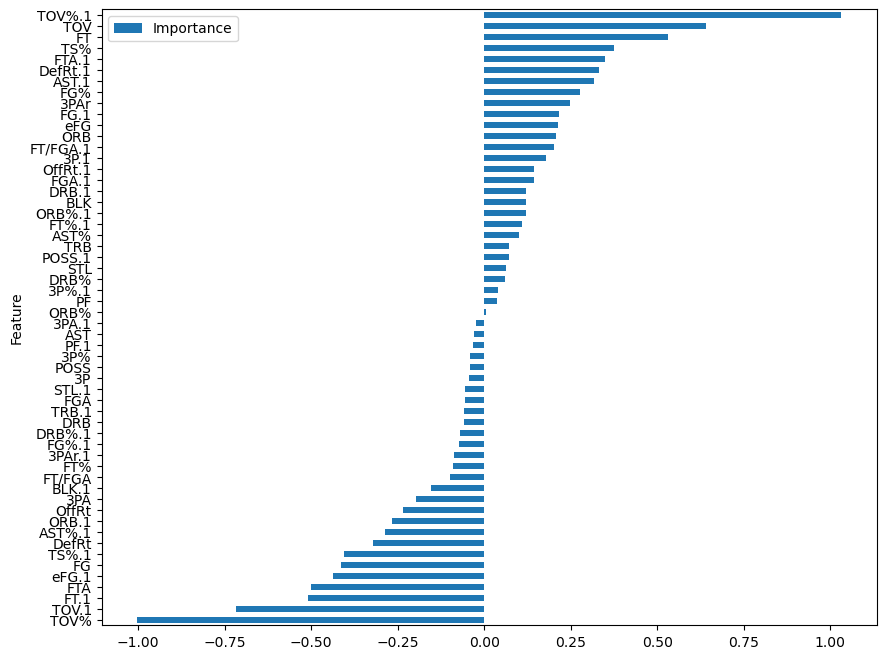

In [34]:
#examining variable importance
coefficients = logreg.coef_[0]
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance':coefficients})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 8))
plt.show()

In [35]:
pd.options.display.max_rows = 70
print(feature_importance)
pd.options.display.max_rows = 10

     Feature  Importance
17      TOV%   -1.004085
42     TOV.1   -0.717364
34      FT.1   -0.507879
7        FTA   -0.499590
44     eFG.1   -0.436988
0         FG   -0.413867
50     TS%.1   -0.404532
27     DefRt   -0.321320
49    AST%.1   -0.285287
37     ORB.1   -0.265382
26     OffRt   -0.234727
4        3PA   -0.196068
41     BLK.1   -0.154054
19    FT/FGA   -0.097876
8        FT%   -0.089088
51    3PAr.1   -0.087530
30     FG%.1   -0.073069
48    DRB%.1   -0.070078
24       DRB   -0.058859
38     TRB.1   -0.058245
1        FGA   -0.056305
40     STL.1   -0.054424
3         3P   -0.042948
25      POSS   -0.040353
5        3P%   -0.040025
43      PF.1   -0.032297
11       AST   -0.029985
32     3PA.1   -0.024320
18      ORB%    0.005405
15        PF    0.037880
33     3P%.1    0.039640
20      DRB%    0.060826
12       STL    0.062775
53    POSS.1    0.070857
10       TRB    0.071683
21      AST%    0.100976
36     FT%.1    0.110072
46    ORB%.1    0.119638
13       BLK    0.119842


## Not all variables seem to be important. As a result a Principal Components Analysis will be conducted to reduce the number of variables

In [38]:
#Creating basic PCA object
pca = PCA(random_state=42)

In [39]:
#fitting basic PCA to the training data
pca.fit(X_train_std)

PCA(random_state=42)

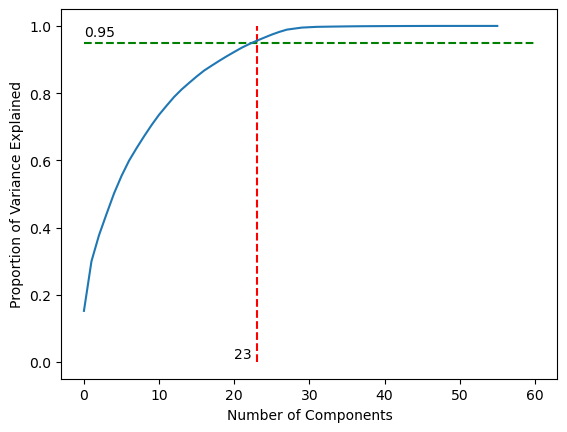

In [58]:
#examining the amount of variance
# it appears that around 23 principal components are needed to retain 95% of the original variance

explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.vlines(x=23, ymax=1, ymin=0, colors="r", linestyles="--")
plt.hlines(y=0.95, xmax=60, xmin=0, colors="g", linestyles="--")
plt.plot(explained_variance)
plt.xlabel("Number of Components")
plt.ylabel("Proportion of Variance Explained")
plt.annotate("23",xy=(20,0.01))
plt.annotate("0.95",xy=(0,0.97))
plt.show()

In [56]:
#Creating a PCA that retains only 95% of the original variance and fitting it to the training data
pca_final = PCA(0.95, random_state = 42)
df_train_pca = pca_final.fit_transform(X_train_std)
df_test_pca = pca_final.transform(X_test_std)

In [76]:
#examining the components and how much variance they explain
var_data = pd.DataFrame()
var_data['component'] = np.arange(1,len(pca_final.explained_variance_ratio_)+1)
var_data['var_ratio'] = pca_final.explained_variance_ratio_

print("Component - ", "Percentage of Variance Accounted For")

for i in range(len(var_data)):
    
    print("      ", var_data['component'][i],"     ",var_data['var_ratio'][i] )

Component -  Percentage of Variance Accounted For
       1       0.1519704518498239
       2       0.14758757624720129
       3       0.07732761681234332
       4       0.06306167999406909
       5       0.06136831397115143
       6       0.052273628638426536
       7       0.04528644938997638
       8       0.03734279556388301
       9       0.03525423059617522
       10       0.03350445757134015
       11       0.030812873870366863
       12       0.026916596573821224
       13       0.026029721308626935
       14       0.022257483515011
       15       0.01958600099901395
       16       0.01899680042828438
       17       0.01772172694859249
       18       0.0145577445472496
       19       0.014242895935729163
       20       0.013634324547219641
       21       0.012885240628394442
       22       0.012607156080143352
       23       0.01087414062596928
       24       0.009845402013695013


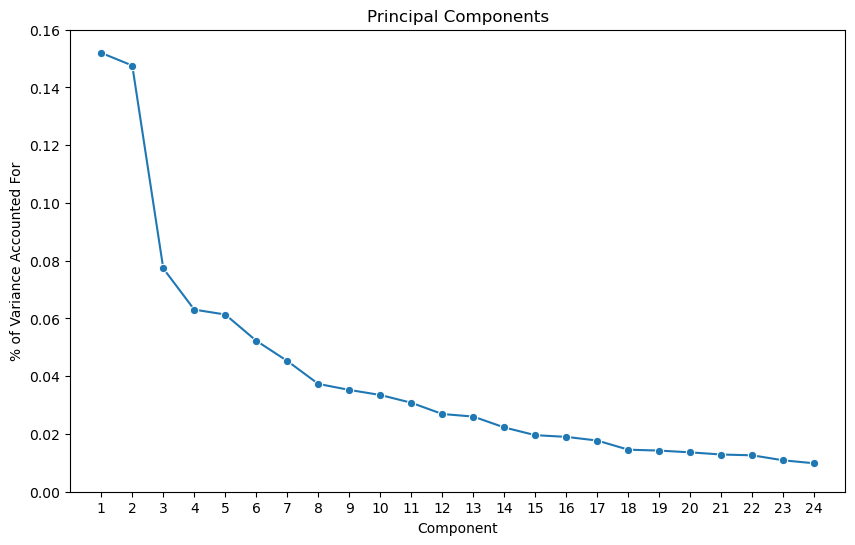

In [34]:
#examining the components visually
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(x='component',y='var_ratio', data = var_data, marker = 'o')
ax.set_xlabel("Component")
ax.set_ylabel("% of Variance Accounted For")
ax.set(title = 'Principal Components')
ax.set(ylim = (0,0.16))
ax.set(xlim = (0,25))
ax.set_xticks(range(1,len(var_data) +1))
plt.show()

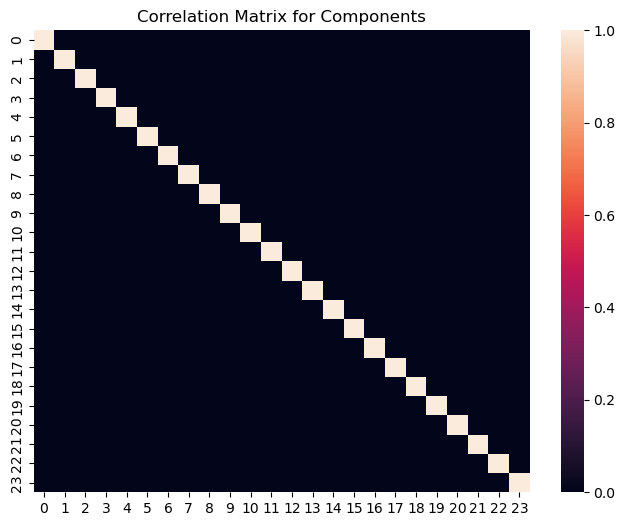

In [35]:
#examining the correlations between the components
fig, ax = plt.subplots(figsize=(8,6))
corr_mat = np.corrcoef(df_train_pca.transpose())
sns.heatmap(corr_mat)
ax.set(title = 'Correlation Matrix for Components')
plt.show()

## The first two components make up about 30% of the variance but 23 components are needed to represent 95% of the original variance. This is still around half the number of features that was used in the original model.

## Now the model will be fit using the principal component transformed data

In [77]:
#creating a logistic regression object and fitting it to the PCA training data
LR_PCA = LogisticRegression(random_state = 42, max_iter = 1000)
LR_PCA.fit(df_train_pca, y_train)

LogisticRegression(max_iter=1000, random_state=42)

Model Performance

Accuracy =  0.643979057591623 

Classification Report

              precision    recall  f1-score   support

           0     0.6478    0.6449    0.6464      1349
           1     0.6401    0.6430    0.6416      1325

    accuracy                         0.6440      2674
   macro avg     0.6440    0.6440    0.6440      2674
weighted avg     0.6440    0.6440    0.6440      2674



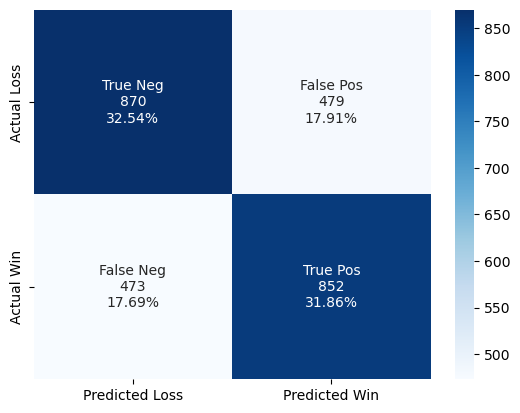

Area Under the Curve = 0.6439705162454369


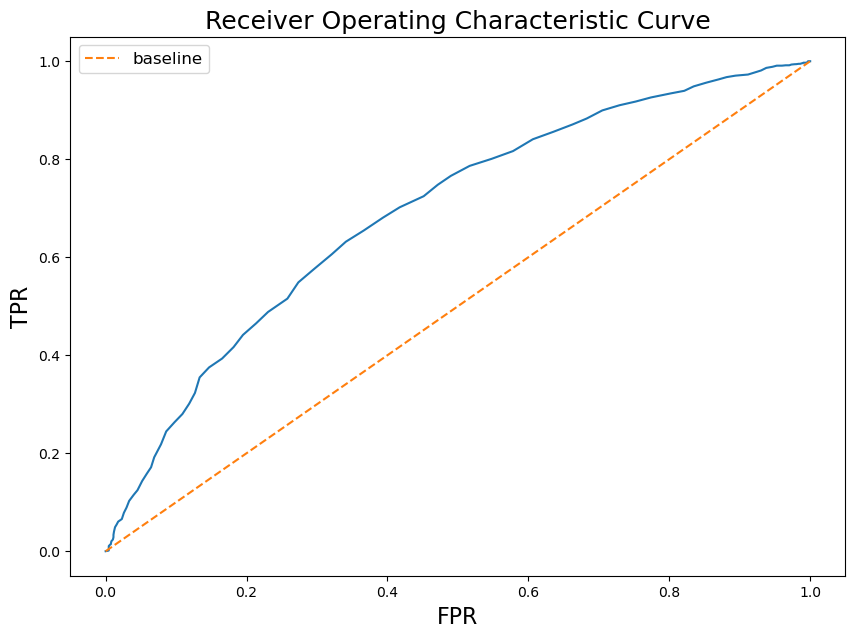

In [78]:
#evaluating the PCA model
evaluate_classification(LR_PCA, df_test_pca, y_test, extra = True)

In [101]:
#comparing the original model to the model using PCA
compare_classification(logreg, LR_PCA, X_test_std, df_test_pca, y_test)

           Model 1 Performance    Model 2 Performance   Difference (Model2 - Model1)
Accuracy:  0.6394913986537023     0.643979057591623     0.004487658937920691


## The PCA model performs better than the original model and will now be used as a benchmark

## Next a alternate method of variable reduction will be conducted called recursive feature elimination with cross-validation RFECV

In [102]:
#creating a base Logistic Regression model object
# then creating a recursive feature elimination object
# then fitting to the training data
LR_estimator = LogisticRegression(random_state=42, max_iter = 5000)
LR_select = RFECV(LR_estimator, step=1, cv=5, n_jobs = -1)
LR_selector = LR_select.fit(X_train_std, y_train)


In [104]:
#examining how many of the original features were retained
(LR_selector.support_).sum()

51

In [105]:
#examining which features were retained
X_train_std.columns[LR_selector.support_]

Index(['FG', 'FGA', 'FG%', '3P', '3PA', '3P%', 'FT', 'FTA', 'FT%', 'ORB',
       'TRB', 'STL', 'BLK', 'TOV', 'eFG', 'TOV%', 'FT/FGA', 'DRB%', 'AST%',
       'TS%', '3PAr', 'DRB', 'POSS', 'OffRt', 'DefRt', 'FG.1', 'FGA.1',
       'FG%.1', '3P.1', '3P%.1', 'FT.1', 'FTA.1', 'FT%.1', 'ORB.1', 'TRB.1',
       'AST.1', 'STL.1', 'BLK.1', 'TOV.1', 'eFG.1', 'TOV%.1', 'ORB%.1',
       'FT/FGA.1', 'DRB%.1', 'AST%.1', 'TS%.1', '3PAr.1', 'DRB.1', 'POSS.1',
       'OffRt.1', 'DefRt.1'],
      dtype='object')

In [106]:
#examining which features were removed
X_train_std.columns[~LR_selector.support_]

Index(['AST', 'PF', 'ORB%', '3PA.1', 'PF.1'], dtype='object')

In [107]:
#creating training data the contains only the retained features
X_train_std_sub = X_train_std[X_train_std.columns[LR_selector.support_]]
X_test_std_sub = X_test_std[X_train_std.columns[LR_selector.support_]]

In [108]:
#creating a base logistic regression object
logreg_sub = LogisticRegression(random_state = 42, max_iter = 1000)

In [109]:
#fitting the model to the subset of features
logreg_sub.fit(X_train_std_sub, y_train)

LogisticRegression(max_iter=1000, random_state=42)

Model Performance

Accuracy =  0.6409872849663426 

Classification Report

              precision    recall  f1-score   support

           0     0.6448    0.6420    0.6434      1349
           1     0.6371    0.6400    0.6386      1325

    accuracy                         0.6410      2674
   macro avg     0.6410    0.6410    0.6410      2674
weighted avg     0.6410    0.6410    0.6410      2674



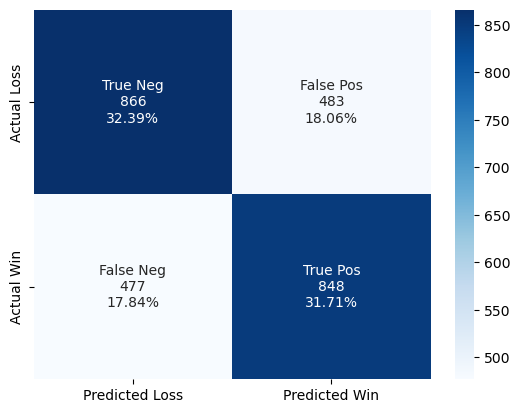

Area Under the Curve = 0.6409785025945145


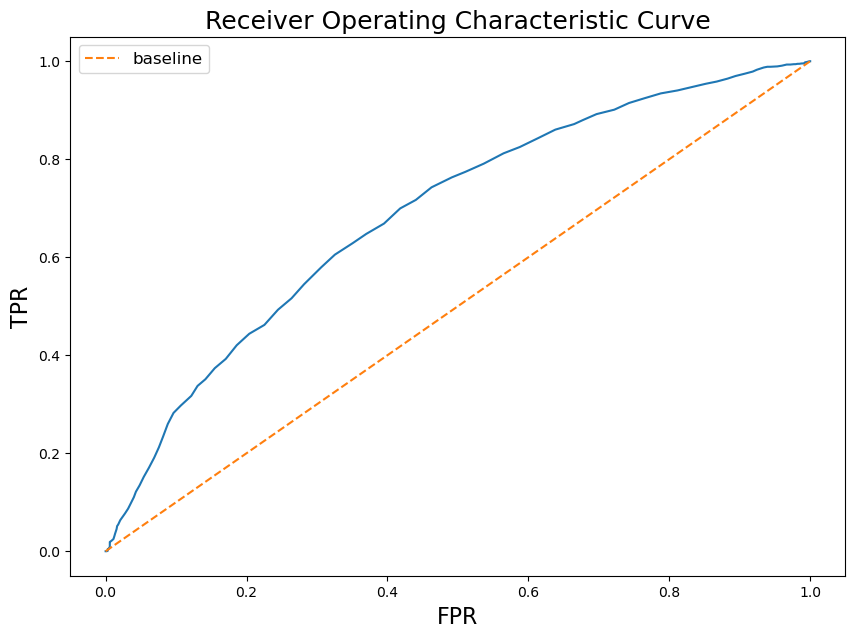

In [110]:
#evaluating reduced features model
evaluate_classification(logreg_sub, X_test_std_sub, y_test, extra = True)

In [111]:
#comparing the RFCVE model to the PCA model
compare_classification(LR_PCA, logreg_sub, df_test_pca, X_test_std_sub, y_test)

           Model 1 Performance    Model 2 Performance   Difference (Model2 - Model1)
Accuracy:  0.643979057591623     0.6409872849663426     -0.0029917726252803867


## The PCA model performed the best out of the models examined with a accuracy around 64.4%